### Parámetros Generales

In [1]:
# Directorio donde se guardaran las listas de téminos generadas
path_lists = "./list_terms/"
# Directorio logs
path_logs = "./logs/"

# Idioma a tratar
language = "eng" # "spa", "ita", "ger", "fre"

Adaptación del proceso de filtrado para que trabajar con él y ver su funcionamiento más en detalle

In [2]:
%pip install spacy lingua-language-detector spacy-langdetect

Note: you may need to restart the kernel to use updated packages.


In [3]:
# !tar -xvf freq.tar.xz
# !tar -xvf extract.tar.xz

In [4]:
!spacy download en_core_web_sm
!spacy download de_core_news_sm
!spacy download fr_core_news_sm
!spacy download it_core_news_sm
!spacy download es_core_news_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 667.8 kB/s eta 0:00:20
      --------------------------------------- 0.2/12.8 MB 2.0 MB/s eta 0:00:07
     -- ------------------------------------- 0.8/12.8 MB 5.4 MB/s eta 0:00:03
     ---- ----------------------------------- 1.6/12.8 MB 8.3 MB/s eta 0:00:02
     -------- ------------------------------- 2.6/12.8 MB 11.2 MB/s eta 0:00:01
     ----------- ---------------------------- 3.8/12.8 MB 13.5 MB/s eta 0:00:01
     --------------- ------------------------ 5.1/12.8 MB 15.5 MB/s eta 0:00:01
     --------------------- ------------------ 7.0/12.8 MB 18.7 MB/s eta 0:00:01
     -------------------------- ------------- 8.3/12.8 MB 20.5 MB/s eta 0:00:01
     -------------------------------- ------ 10.5/12.8 MB 28.5 MB/s eta 0:00:01
     ------------------------------------- - 12.3/12.8 MB 32.8 MB/s eta 0:00:01
     --------------------------------------  12.8/1

**Importación de librerías**

In [5]:
import os
import spacy
import json
import lingua
import matplotlib.pyplot as plt
import pandas as pd

from langdetect import detect
from spacy.language import Language
from spacy_langdetect import LanguageDetector

In [6]:
# Spacy

spacy_models = json.loads('''{
	"bul": {"sm": null, "lg": null},
	"hrv": {"sm": "hr_core_news_sm", "lg": "hr_core_news_lg"},
	"cze": {"sm": null, "lg": null},
	"dan": {"sm": "da_core_news_sm", "lg": "da_core_news_trf"},
	"dut": {"sm": "nl_core_news_sm", "lg": "nl_core_news_lg"},
	"eng": {"sm": "en_core_web_sm", "lg": "en_core_web_trf"},
	"est": {"sm": null, "lg": null},
	"fin": {"sm": "fi_core_news_sm", "lg": "fi_core_news_lg"},
	"fre": {"sm": "fr_core_news_sm", "lg": "fr_dep_news_trf"},
	"ger": {"sm": "de_core_news_sm", "lg": "de_dep_news_trf"},
	"gre": {"sm": "el_core_news_sm", "lg": "el_core_news_lg"},
	"hun": {"sm": null, "lg": null},
	"gle": {"sm": null, "lg": null},
	"ita": {"sm": "it_core_news_sm", "lg": "it_core_news_lg"},
	"lav": {"sm": null, "lg": null},
	"lit": {"sm": "lt_core_news_sm", "lg": "lt_core_news_lg"},
	"mlt": {"sm": null, "lg": null},
	"pol": {"sm": "pl_core_news_sm", "lg": "pl_core_news_lg"},
	"por": {"sm": "pt_core_news_sm", "lg": "pt_core_news_lg"},
	"rum": {"sm": "ro_core_news_sm", "lg": "ro_core_news_lg"},
	"rus": {"sm": "ru_core_news_sm", "lg": "ru_core_news_lg"},
	"slo": {"sm": null, "lg": null},
	"slv": {"sm": null, "lg": null},
	"spa": {"sm": "es_core_news_sm", "lg": "es_dep_news_trf"},
	"swe": {"sm": null, "lg": null}
}''')

freq_list = {"spa": {}, "ger": {}, "fre": {}, "eng": {}, "ita": {}}

freq_list["spa"]["1-gram"] = open("./freq/spa/spa-1gram.txt").read().split("\n")
freq_list["ger"]["1-gram"] = open("./freq/ger/ger-1gram.txt").read().split("\n")
freq_list["fre"]["1-gram"] = open("./freq/fre/fre-1gram.txt").read().split("\n")
freq_list["eng"]["1-gram"] = open("./freq/eng/eng-1gram.txt").read().split("\n")
freq_list["ita"]["1-gram"] = open("./freq/ita/ita-1gram.txt").read().split("\n")

freq_list["spa"]["2-gram"] = open("./freq/spa/spa-2gram.txt").read().split("\n")
freq_list["ger"]["2-gram"] = open("./freq/ger/ger-2gram.txt").read().split("\n")
freq_list["fre"]["2-gram"] = open("./freq/fre/fre-2gram.txt").read().split("\n")
freq_list["eng"]["2-gram"] = open("./freq/eng/eng-2gram.txt").read().split("\n")
freq_list["ita"]["2-gram"] = open("./freq/ita/ita-2gram.txt").read().split("\n")

lingua_langs = {
		"eng": lingua.Language.ENGLISH,
		"spa": lingua.Language.SPANISH,
		"ita": lingua.Language.ITALIAN,
		"ger": lingua.Language.GERMAN,
		"fre": lingua.Language.FRENCH
	}

langs_used = [v for k,v in lingua_langs.items()]

lang_detector = lingua.LanguageDetectorBuilder.from_languages(*langs_used).build()

In [7]:
print(langs_used)
print(type(lingua_langs), lingua_langs)

[Language.ENGLISH, Language.SPANISH, Language.ITALIAN, Language.GERMAN, Language.FRENCH]
<class 'dict'> {'eng': Language.ENGLISH, 'spa': Language.SPANISH, 'ita': Language.ITALIAN, 'ger': Language.GERMAN, 'fre': Language.FRENCH}


**Cargar diccionarios 1-gram, 2-gram**

In [8]:
def load_dictionaries(lang, filter_deep_1g = 50000, filter_deep_2g = 1000000):

	dict_1g = {}
	dict_2g = {}

	if (lang in freq_list) and ("1-gram" in freq_list[lang]):

		lower_list = [t.lower() for t in freq_list[lang]["1-gram"][:filter_deep_1g]]

		dict_1g = dict(zip(lower_list, range(len(lower_list))))

	if (lang in freq_list) and ("2-gram" in freq_list[lang]):

		lower_list = [t.lower() for t in freq_list[lang]["2-gram"][:filter_deep_2g]]

		dict_2g = dict(zip(lower_list, range(len(lower_list))))
  
	return dict_1g, dict_2g

**Funciones para detectar el idioma utilizando Spacy**

In [9]:
@Language.factory("language_detector")
def create_language_detector(nlp, name):
    return LanguageDetector()

def load_spacy_model(language="eng"):
    nlp = spacy.load(spacy_models[language]["sm"])
    nlp.add_pipe("language_detector")
    return nlp

def detect_language(nlp, text):
    doc = nlp(text)
    return doc._.language['language']

# Prueba para detectar el idioma utilizando Spacy
pipe = load_spacy_model("eng")
text = 'This is an english text.'
lang = detect_language(pipe, text)
print(lang)

en


**Filtrado de términos**

In [10]:
def filter_terms(lines, lang):

	log = []
	terms = {}
	stats = {'1-gram': 0, '2-gram': 0, 'short': 0, 'symbol': 0, 'caps': 0, 'no_NE': 0, 'lang': 0}
	 
	for term in lines:

		freq, term = term.replace("\n", "").split("\t")

		term = term.replace("-", " ").replace("  ", " ")

		if (lang in freq_list) and ("1-gram" in freq_list[lang]) and (term.lower() in dict_1g):

			log_text = f"Excluding {term} (too freq 1-gram)"
			log.append(log_text)
			# print(log_text)
			# print("Excluding", term, "(too freq 1-gram)")
			stats["1-gram"] += 1

		elif (lang in freq_list) and ("2-gram" in freq_list[lang]) and (term.lower() in dict_2g):

			log_text = f"Excluding {term} (too freq 2-gram)"
			log.append(log_text)
			# print(log_text)
			# print("Excluding", term, "(too freq 2-gram)")
			stats["2-gram"] += 1

		elif any(len(word) < 4 for word in term.split(" ")):

			log_text = f"Excluding {term} (too short)"
			log.append(log_text)
			# print(log_text)
			# print("Excluding", term, "(too short)")
			stats["short"] += 1   

		elif not term.replace(" ", "").replace("'", "").replace("-","").isalpha() or term.replace(" ", "").startswith("-") or term.replace(" ", "").endswith("-"):

			log_text = f"Excluding {term} (strange symbols)"
			log.append(log_text)
			# print(log_text)
			# print("Excluding", term, "(strange symbols)")
			stats["symbol"] += 1

		else:

			log_text = f"Adding {term}"
			log.append(log_text)
			# print(log_text)
			# print("Adding", term)
			terms[term] = {"f": freq}

	# Las diferencias de capitalizacion se resuelven optando por la version mas habitual

	for term, _ in terms.copy().items():
     
		if term.lower() != term and term.lower() in terms:
      
			stats["caps"] += 1

			if int(terms[term.lower()]["f"]) > int(terms[term]["f"]):

				terms.pop(term)
				log_text = f"Excluding {term} (duplicated and less frequent capitalization)"
				log.append(log_text)
				# print(log_text)
				# print("Excluding", term, "(duplicated and less frequent capitalization)")
    
			else:

				terms.pop(term.lower())
				log_text = f"Excluding {term.lower()} (duplicated and less frequent capitalization)"
				log.append(log_text)
				# print(log_text)
				# print("Excluding", term.lower(), "(duplicated and less frequent capitalization)")
    
	valid_NE = ["EVENT", "FAC", "ORG", "WORK_OF_ART"]

	pipe = spacy.load(spacy_models[lang]["sm"])

	# Se excluyen términos con alguna palabra que no sea una entidad nominal (NE) (token en valid_NE) 
	for term, _ in terms.copy().items():

		doc = pipe(term)

		for token in doc.ents:

			log_text = f"Valid NE: {token} {token.label_}"
			log.append(log_text)
			# print(log_text)
			# print('Valid NE: ', token, ' ', token.label_)
			if not (token.label_ in valid_NE) and term in terms:

				terms.pop(term)
				log_text = f"Excluding {term} (not valid NE)"
				log.append(log_text)
				# print(log_text)
				# print("Excluding", term, "(not valid NE)")
				stats["no_NE"] += 1

	# Se excluyen términos en otros idiomas
	for term, _ in terms.copy().items():

			doc = pipe(term)
			language = doc._.language
   
			language2 = detect(term)

			detected = lang_detector.detect_language_of(term)

			log_text = f"Term: {term} | lang_detector: {detected} | Spacy: {language} | langdetect: {language2}"
			log.append(log_text)
			# print(log_text)
			# print('Term: ', term, " | lang_detector: ", detected, " | Spacy: ", language, " | langdetect: ", language2)

			if lang in lingua_langs and detected != lingua_langs[lang]:

				terms.pop(term)
				log_text = f"Excluding {term} (different language - {detected.name})"
				log.append(log_text)
				# print(log_text)
				# print("Excluding", term, "(different language - ", detected.name,")")
				stats["lang"] += 1

	total_stats = 0
	for k, v in stats.items():
		print("Excluded by", k, "\t>\t", v)
		total_stats += v
	print("Total terms excluded\t>\t", total_stats)

	return terms, log

Prueba Funcionamiento Lematización

In [11]:
pipe = spacy.load(spacy_models["eng"]["sm"])

words = ['motor learning theories', 'learning']

for word in words:
    doc = pipe(word)
    full_token = []
 
    for token in doc:
        print(token.lemma_)
        full_token.append(token.lemma_)
        print(full_token)


    lemma = " ".join(full_token)
    print("Lemma: ", lemma, " vs word: ", word)

motor
['motor']
learning
['motor', 'learning']
theory
['motor', 'learning', 'theory']
Lemma:  motor learning theory  vs word:  motor learning theories
learn
['learn']
Lemma:  learn  vs word:  learning


**Lematización**

In [12]:
def lemmatize_terms(terms, lang):

	log = []
	lemmatized_terms = {}
	stats = {'1-gram': 0, '2-gram': 0}

	pipe = spacy.load(spacy_models[lang]["sm"])

	term_list_old = list(terms.keys())

	for term in term_list_old:

		doc = pipe(term)

		full_token = []

		for token in doc:

			full_token.append(token.lemma_)

		lemma = " ".join(full_token)

		if term in terms:

			old_f = terms[term]

			if lemma in lemmatized_terms:

				current_f = lemmatized_terms[lemma]

				new_f = current_f["f"] + old_f["f"] # Varias palabras convergen en una raíz

				lemmatized_terms[lemma] = {"f": new_f}

			else:

				lemmatized_terms[lemma] = {"f": old_f["f"]}


	for term in lemmatized_terms.copy().keys():

    # Solo se extá empleando en "eng" porque la lematización en otras cambia
    # también otras flexiones y es algo a evitar.

		if lang == "eng":

			if (term.lower() in dict_1g):

				log_text = f"Excluding {term} (too freq 1-gram) lemma"
				log.append(log_text)
				# print(log_text)

				lemmatized_terms.pop(term)
    
				stats["1-gram"] += 1

			elif (term.lower() in dict_2g):

				log_text = f"Excluding {term} (too freq 2-gram) lemma"
				log.append(log_text)
				# print(log_text)

				lemmatized_terms.pop(term)
    
				stats["2-gram"] += 1
    
	total_stats = 0
	for k, v in stats.items():
		print("Excluded by", k, "\t>\t", v)
		total_stats += v
	print("Total terms excluded\t>\t", total_stats)

	return lemmatized_terms, log

Muestra los 10 términos con mayor ocurrencia

In [13]:
def show_terms(terms, limit=10):
    print(f'Términos encontrados: {len(terms)}')

    cont = 0
    for clave, valor in terms:
        print(f'Término: {clave}, Frecuencia: {valor["f"]}')
        cont += 1
        
        if cont > limit:
            break

Verifica existencia de directorio donde se guardarán los ficheros json con la lista de términos

In [14]:
def check_path(path_lists):
    if not os.path.exists(path_lists):
        os.makedirs(path_lists)
        print(f"Directorio '{path_lists}' creado.")
    else:
        print(f"El directorio '{path_lists}' ya existe.")
        
check_path(path_lists)
check_path(path_logs)

El directorio './list_terms/' ya existe.
El directorio './logs/' ya existe.


Función para creación nombre del fichero

In [15]:
def get_name_file(path, text, language, param_1g, param_2g):
    
    if path.endswith("/"):
        path = path[:-1]  # Elimina el último carácter

    name_list = path + "/" + text + "_" + language + "_" + str(param_1g) + "_" + str(param_2g)
    
    return name_list

### Creación listas de términos con distintos valores 1-gram, 2-gram

In [16]:
list_terms_example = open("./extract/eng/occupational_therapy/terms.txt").readlines()

values_filter_deep_1g = [20000, 30000, 40000, 50000, 60000]
values_filter_deep_2g = [300000, 400000, 500000, 600000, 700000]

# Lista para almacenar los resultados
results = []  

for filter_deep_1g in values_filter_deep_1g:
    
    for filter_deep_2g in values_filter_deep_2g:

        dict_1g, dict_2g = load_dictionaries(language, filter_deep_1g, filter_deep_2g)

        print("="*50)
        print(f"Filtrado - 1-gram: {filter_deep_1g}, 2-gram: {filter_deep_2g}")
        terms, log_filter = filter_terms(list_terms_example, language)
        # print(terms)

        print("="*50)
        print(f"Lematización - 1-gram: {filter_deep_1g}, 2-gram: {filter_deep_2g}")
        terms, log_lemma = lemmatize_terms(terms, language)
        print(terms)
        
        # Se ordenan términos de forma descendiente según su frecuencia
        sorted_terms = sorted(terms.items(), key=lambda x: int(x[1]["f"]), reverse=True)
        print("sorted_terms: ", sorted_terms)
        
        print("=============== Términos principales ===============")
        show_terms(sorted_terms)
        
        results.append({
            'filter_deep_1g': filter_deep_1g,
            'filter_deep_2g': filter_deep_2g,
            'terms': len(sorted_terms)
        })
        
        json_content = {
            'filter_deep_1g': filter_deep_1g,
            'filter_deep_2g': filter_deep_2g,
            'terms': sorted_terms
        }
        
        term_path_file = get_name_file(path_lists, "terms_list", language, filter_deep_1g, filter_deep_2g)
        term_path_file += ".json"
        
        log_path_file = get_name_file(path_logs, "log", language, filter_deep_1g, filter_deep_2g)
        log_path_file += ".txt"
        
        # Escribir el diccionario 'terms' en un fichero JSON
        with open(term_path_file, 'w') as json_file:
            json.dump(json_content, json_file)

        # Escribir ambas variables log en el mismo fichero plano
        with open(log_path_file, 'w') as log_file:

            # Escribir elementos de log_filter en líneas separadas
            for item in log_filter:
                log_file.write(str(item) + "\n")

            # Agregar una línea como separador
            log_file.write("======log_lemma======\n")

            # Escribir elementos de log_lemma en líneas separadas
            for item in log_lemma:
                log_file.write(str(item) + "\n")
            
        print("=============== Ficheros generados ===============")
        print(f'Fichero {term_path_file} guardado')
        print(f'Fichero {log_path_file} guardado')
        

Filtrado - 1-gram: 20000, 2-gram: 300000


Excluded by 1-gram 	>	 992
Excluded by 2-gram 	>	 497
Excluded by short 	>	 1132
Excluded by symbol 	>	 158
Excluded by caps 	>	 90
Excluded by no_NE 	>	 146
Excluded by lang 	>	 290
Total terms excluded	>	 3305
Lematización - 1-gram: 20000, 2-gram: 300000
Excluded by 1-gram 	>	 21
Excluded by 2-gram 	>	 14
Total terms excluded	>	 35
{'motor learning': {'f': '98'}, 'occupational therapist': {'f': '76'}, 'pediatric occupational therapy': {'f': '59'}, 'occupational therapy practice': {'f': '39'}, 'global performance': {'f': '26'}, 'pediatric occupational therapist': {'f': '255'}, 'motor learning theory': {'f': '2414'}, 'collaborative practice': {'f': '239'}, 'escape room': {'f': '221'}, 'rating scale score': {'f': '221'}, 'pediatric practice': {'f': '21'}, 'global performance score': {'f': '184'}, 'learn theory': {'f': '18'}, 'residency': {'f': '16'}, 'Therapy International': {'f': '15'}, 'standardize assessment': {'f': '141'}, 'Therapy Association': {'f': '13'}, 'Structured Clinical': {

In [17]:
for result in results:
    print(f"filter_deep_1g: {result['filter_deep_1g']}, filter_deep_2g: {result['filter_deep_2g']}, terms: {result['terms']}")

filter_deep_1g: 20000, filter_deep_2g: 300000, terms: 1508
filter_deep_1g: 20000, filter_deep_2g: 400000, terms: 1443
filter_deep_1g: 20000, filter_deep_2g: 500000, terms: 1393
filter_deep_1g: 20000, filter_deep_2g: 600000, terms: 1351
filter_deep_1g: 20000, filter_deep_2g: 700000, terms: 1311
filter_deep_1g: 30000, filter_deep_2g: 300000, terms: 1482
filter_deep_1g: 30000, filter_deep_2g: 400000, terms: 1417
filter_deep_1g: 30000, filter_deep_2g: 500000, terms: 1367
filter_deep_1g: 30000, filter_deep_2g: 600000, terms: 1325
filter_deep_1g: 30000, filter_deep_2g: 700000, terms: 1285
filter_deep_1g: 40000, filter_deep_2g: 300000, terms: 1477
filter_deep_1g: 40000, filter_deep_2g: 400000, terms: 1412
filter_deep_1g: 40000, filter_deep_2g: 500000, terms: 1362
filter_deep_1g: 40000, filter_deep_2g: 600000, terms: 1320
filter_deep_1g: 40000, filter_deep_2g: 700000, terms: 1280
filter_deep_1g: 50000, filter_deep_2g: 300000, terms: 1469
filter_deep_1g: 50000, filter_deep_2g: 400000, terms: 14

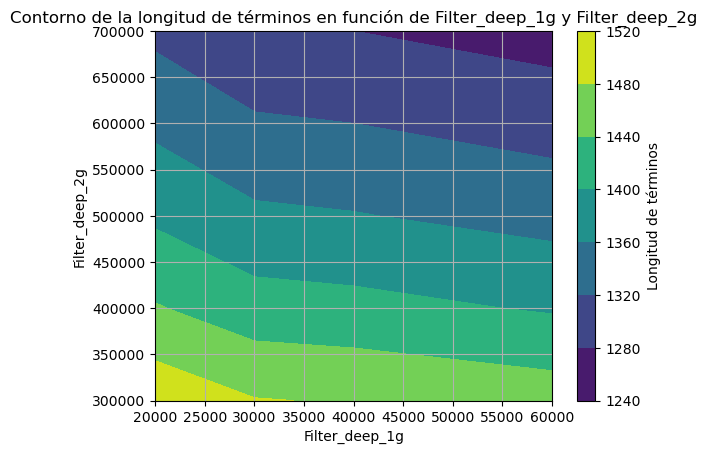

In [18]:
# Obtener valores para el gráfico
x = [result['filter_deep_1g'] for result in results]
y = [result['filter_deep_2g'] for result in results]
z = [result['terms'] for result in results]

# Crear el gráfico de contorno 2D
plt.tricontourf(x, y, z, cmap='viridis')  # 'tricontourf' para gráfico de contorno
plt.colorbar(label='Longitud de términos')
plt.xlabel('Filter_deep_1g')
plt.ylabel('Filter_deep_2g')
plt.title('Contorno de la longitud de términos en función de Filter_deep_1g y Filter_deep_2g')

# Añadir un grid
plt.grid(True)

# Mostrar el gráfico
plt.show()

In [19]:
# Obtener valores para el gráfico
x = [result['filter_deep_1g'] for result in results]
y = [result['filter_deep_2g'] for result in results]
z = [result['terms'] for result in results]

# Crear un DataFrame con pandas
data = {'filter_deep_2g': y, 'filter_deep_1g': x, 'length_terms': z}
df = pd.DataFrame(data)

# Pivotar los datos para mostrarlos como una tabla
pivot_table = df.pivot(index='filter_deep_1g', columns='filter_deep_2g', values='length_terms')

# Mostrar la tabla
print(pivot_table)

filter_deep_2g  300000  400000  500000  600000  700000
filter_deep_1g                                        
20000             1508    1443    1393    1351    1311
30000             1482    1417    1367    1325    1285
40000             1477    1412    1362    1320    1280
50000             1469    1404    1354    1312    1272
60000             1461    1396    1346    1304    1264


**Categorías gramaticales del último conjunto de términos extraidos**

In [22]:
nlp = spacy.load(spacy_models[language]["sm"])

lista = [elem[0] for elem in json_content['terms']]
print(lista)

# Diccionario para almacenar las estadísticas de las categorías gramaticales
words_by_pos_with_counts = {}

# Iterar sobre cada elemento de la lista de texto
for texto in lista:
    # Procesar el texto con Spacy
    doc = nlp(texto)
    
    # Obtener los POS tags para cada palabra del texto
    for token in doc:
        
        pos_tag = token.pos_
        word = token.text
        
        # Almacenar la palabra y su contador según su categoría gramatical
        if pos_tag in words_by_pos_with_counts:
            if word in words_by_pos_with_counts[pos_tag]:
                words_by_pos_with_counts[pos_tag][word] += 1
            else:
                words_by_pos_with_counts[pos_tag][word] = 1
        else:
            words_by_pos_with_counts[pos_tag] = {word: 1}           


['motor learning theory', 'pediatric occupational therapist', 'collaborative practice', 'escape room', 'rating scale score', 'global performance score', 'standardize assessment', 'occupational therapy practitioner', 'virtual escape room', 'SBOT practice', 'pediatric setting', 'occupational therapy service', 'pediatric occupational therapy', 'occupational therapy intervention', 'online survey', 'clinical competency', 'waitlist', 'intervention approach', 'practice technique', 'occupational therapy practice', 'service delivery model', 'practice schedule', 'subscale', 'sensory intervention', 'standardize patient', 'patient case', 'global performance', 'pediatric practice', 'clinical competence', 'clinical skill center', 'cognitive orientation', 'functional goal', 'Therapy International', 'Structured Clinical', 'motor learn principle', 'virtual escape', 'evidence Synthesis', 'American Occupational', 'contemporary theory', 'virtual platform', 'contextual interference effect', 'motor learning

**Estadísticas Categorías Gramaticales**

In [23]:
# Imprimir las palabras y sus contadores separados por categoría gramatical
categories = {}
for pos_tag, words_counts in words_by_pos_with_counts.items():
    print(f"{pos_tag}: {len(words_counts)}")
    categories[pos_tag] = len(words_counts)
    for word, count in words_counts.items():
        print(f"  {word}: {count}")

NOUN: 550
  motor: 27
  learning: 21
  theory: 17
  therapist: 23
  practice: 56
  room: 15
  rating: 5
  scale: 2
  score: 6
  performance: 11
  assessment: 14
  therapy: 78
  practitioner: 5
  escape: 6
  setting: 5
  service: 21
  intervention: 29
  survey: 13
  competency: 6
  waitlist: 3
  approach: 17
  technique: 1
  delivery: 11
  model: 11
  schedule: 6
  patient: 3
  case: 4
  competence: 2
  skill: 25
  center: 3
  orientation: 3
  goal: 7
  principle: 4
  evidence: 3
  platform: 4
  interference: 2
  effect: 6
  guidance: 5
  referral: 5
  coefﬁcient: 2
  school: 19
  area: 6
  ratio: 1
  question: 5
  movement: 11
  curriculum: 4
  review: 12
  examinee: 1
  interexaminer: 2
  reliability: 5
  simulation: 9
  resident: 3
  reproduction: 1
  reasoning: 4
  system: 8
  habit: 1
  pmr: 2
  module: 4
  coordination: 2
  disorder: 4
  integration: 2
  expert: 6
  validity: 6
  education: 22
  response: 7
  shift: 2
  bias: 3
  index: 4
  residency: 11
  novice: 1
  analysis: 8


Categorías menos frecuentes

In [24]:
sorted_categories = sorted(categories.items(), key=lambda x: x[1])
four_minors = dict(sorted_categories[:4])
select_categories = [k for k, v in four_minors.items()]
print(select_categories)

['PRON', 'INTJ', 'ADP', 'ADV']


Términos que incluyen palabras de las categorías menos frecuentes

In [25]:
# Diccionario con las palabras y sus contadores según su categoría gramatical (previamente generado)

# Obtener las palabras de interés en esas categorías
select_words = set()
for category in select_categories:
    if category in words_by_pos_with_counts:
        select_words.update(words_by_pos_with_counts[category].keys())

# Buscar elementos en la lista que contengan palabras de interés
found_elements = []
for element in lista:
    doc = nlp(element)
    palabras_elemento = set(token.text for token in doc)
    if select_words.intersection(palabras_elemento):
        found_elements.append(element)

# Imprimir los elementos que contienen palabras de las categorías gramaticales de interés
for element in found_elements:
    print(element)


online survey
likeliness
online datum collection
crosssectional online survey
only gray literature
online encrypted survey
everyday routine
well interpersonal communication
toward Occupational
right upper extremity
more learner
more frequent intervention
whenreferencingthis article
well movement quality
more exposure
above theory
well assessment skill
right cerebral dysfunction
far professional training
most therapist
tiere service delivery
like environment
right support
